# Welcome to this notebook!

This notebook explores two applications of Principal Component Analysis (PCA):

1.  **Dimensionality Reduction and Visualization:** Applying PCA to the Iris dataset to reduce its dimensions and visualize the data in a lower-dimensional space.
2.  **Image Compression:** Using PCA to compress an image by representing it with fewer components.

Feel free to run the cells and explore the results!

# Experiment-1: PCA for Iris dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Loading data

In [ ]:
iris = datasets.load_iris()
X = StandardScaler().fit_transform(iris.data)
y = iris.target

## Fitting the PCA

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X)

## Visualization of cummulative explained variance

This cell generates a plot showing the cumulative explained variance ratio as the number of principal components increases. This plot helps determine how many components are needed to retain a certain percentage of the total variance in the data (in this case, a red dashed line is shown at 95%).

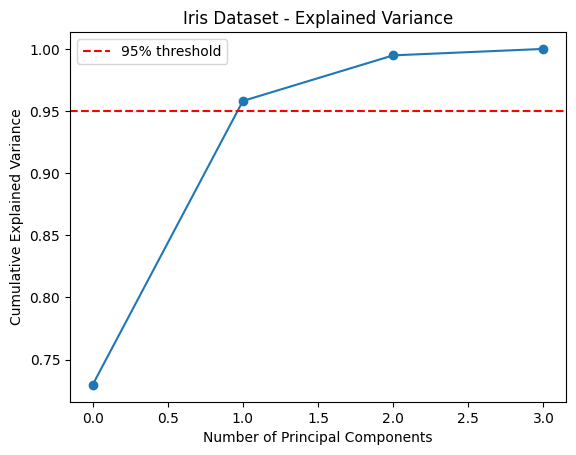

In [ ]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Iris Dataset - Explained Variance")
plt.axhline(0.95, color='r', linestyle='--', label="95% threshold")
plt.legend()
plt.show()

## PCA fitting to 2 features

In [ ]:
pca2 = PCA(n_components=2)
X2 = pca2.fit_transform(X)

## Visualization of first 2 PCs of Iris dataset

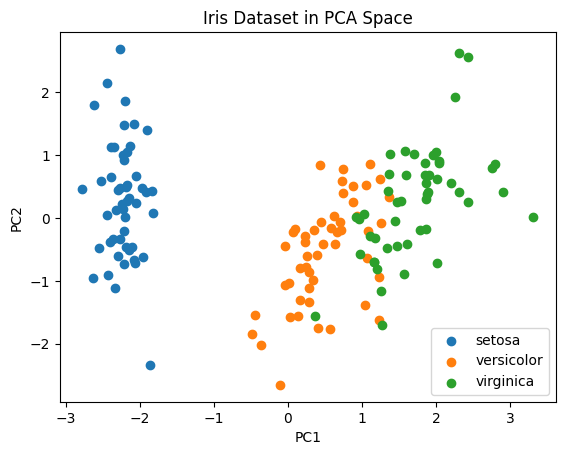

In [ ]:
plt.figure()
for c, label in zip([0,1,2], iris.target_names):
    plt.scatter(X2[y==c,0], X2[y==c,1], label=label)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Iris Dataset in PCA Space")
plt.legend()
plt.show()

## Observations

*   **Cumulative Explained Variance Plot:** The plot shows that with just two principal components, we can explain a significant portion of the variance in the Iris dataset. The plot crosses the 95% threshold line between 1 and 2 components, indicating that two components are sufficient to retain most of the information.
*   **PCA Space Visualization:** The scatter plot clearly shows that the first two principal components effectively separate the different species of Iris flowers. The 'setosa' species is distinctly clustered, while 'versicolor' and 'virginica' show some overlap but are still largely separable. This suggests that the first two principal components capture the most important features for distinguishing between the species.

# Experiment-2: Image compression using PCA

We'll load an image of our choice, convert it to grayscale for clarity, and treat each **image row as a sample**: that is, the image matrix shape `(height, width)` will be used as data `X` with `height` samples and `width` features.  
Fitting PCA on these rows finds column-wise basis vectors (like horizontal patterns). Reconstructing with fewer principal components approximates the image using a low-rank representation — visually this looks like progressive smoothing/blurring as `k` decreases.

We will:
- try multiple `k` values,
- show original vs reconstructions,
- compute MSE and an approximate compression ratio.

Notes:
- You can also run PCA per color channel (RGB) — I provide that option below.
- For smaller width/height images this runs fast; resize larger images for speed if needed.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import os

## USER parameters

In [ ]:
image_path = "your_image.jpg"   # <- replace with your image path
as_color = False                # False -> grayscale; True -> color (per-channel PCA)
resize_to = None                # e.g. (256, 256) to resize for speed, or None to keep original
components_list = [5, 15, 30, 60]  # k's to try (tune based on image width)
cmap = 'gray'                   # plotting colormap for grayscale

## Helper functions

In [ ]:
def load_image(path, resize_to=None):
    """Load an image and optionally resize, returns PIL image."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Image not found at {path}. Replace 'image_path' with a valid path.")
    img = Image.open(path)
    if resize_to:
        img = img.resize(resize_to, Image.LANCZOS)
    return img

def image_to_gray_array(img):
    """Convert PIL image to grayscale float array in [0,1]."""
    gray = img.convert('L')  # 'L' mode = 8-bit grayscale
    arr = np.asarray(gray).astype(float) / 255.0
    return arr

def image_to_rgb_array(img):
    """Convert PIL image to RGB float array in [0,1]. Shape (H,W,3)."""
    rgb = img.convert('RGB')
    arr = np.asarray(rgb).astype(float) / 255.0
    return arr

def pca_reconstruct_rows(X, k):
    """
    Fit PCA treating rows of X as samples and columns as features.
    X shape: (H, W)
    Returns reconstructed X_hat shape (H, W) and the fitted pca.
    """
    pca = PCA(n_components=k, svd_solver='auto')
    Z = pca.fit_transform(X)       # (H, k)
    X_hat = pca.inverse_transform(Z)  # (H, W)
    return X_hat, pca

def compress_size_estimate(height, width, k, dtype_bytes=8):
    """
    Rough bytes to store PCA representation for one-channel image:
    - mean vector: width * dtype_bytes
    - components: k * width * dtype_bytes
    - scores: height * k * dtype_bytes
    Note: dtype_bytes=8 assumes float64. In practice you can store floats in float32 (4 bytes).
    """
    mean_bytes = width * dtype_bytes
    comps_bytes = k * width * dtype_bytes
    scores_bytes = height * k * dtype_bytes
    total = mean_bytes + comps_bytes + scores_bytes
    original = height * width * dtype_bytes
    return total, original

## Loading image and visualization

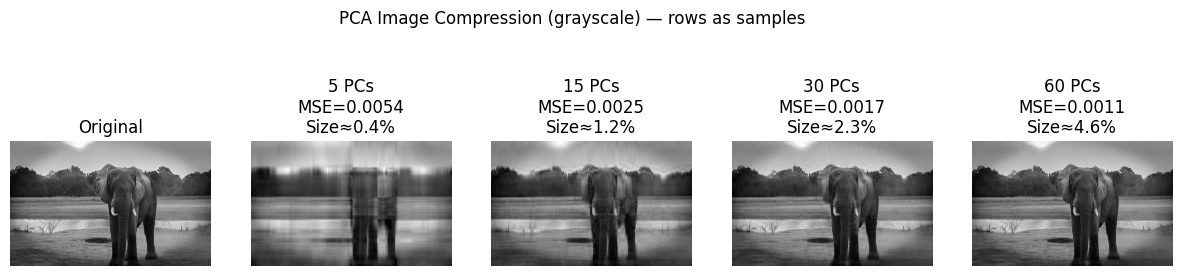

k=5: reconstruction MSE=0.00545, approx storage=0.4% of original
  explained variance ratios (first min(5,k)) = [0.58711844 0.15886476 0.04765318 0.03711899 0.02359204]
  cumulative first min(5) = [0.58711844 0.7459832  0.79363638 0.83075537 0.8543474 ]

k=15: reconstruction MSE=0.00246, approx storage=1.2% of original
  explained variance ratios (first min(5,k)) = [0.58711844 0.15886476 0.04765318 0.03711899 0.02359204]
  cumulative first min(5) = [0.58711844 0.7459832  0.79363638 0.83075537 0.8543474 ]

k=30: reconstruction MSE=0.00165, approx storage=2.3% of original
  explained variance ratios (first min(5,k)) = [0.58711844 0.15886476 0.04765318 0.03711899 0.02359204]
  cumulative first min(5) = [0.58711844 0.7459832  0.79363638 0.83075537 0.8543474 ]

k=60: reconstruction MSE=0.00107, approx storage=4.6% of original
  explained variance ratios (first min(5,k)) = [0.58711844 0.15886476 0.04765318 0.03711899 0.02359204]
  cumulative first min(5) = [0.58711844 0.7459832  0.79363638 0

In [ ]:
img = load_image(image_path, resize_to=resize_to)

# --- Option 1: Grayscale PCA (default) ---
if not as_color:
    arr = image_to_gray_array(img)     # shape: (H, W)
    H, W = arr.shape
    X = arr.copy()
    # Centering: PCA in sklearn centers automatically (fit_transform subtracts mean).
    results = []
    for k in components_list:
        X_hat, pca = pca_reconstruct_rows(X, k)
        # Clip to valid range [0,1]
        X_hat_clipped = np.clip(X_hat, 0.0, 1.0)
        mse = mean_squared_error(X, X_hat_clipped)
        total_bytes, orig_bytes = compress_size_estimate(H, W, k, dtype_bytes=8)
        ratio = total_bytes / orig_bytes
        results.append((k, X_hat_clipped, mse, ratio, pca.explained_variance_ratio_.copy()))

    # Plot original + reconstructions
    n = len(results) + 1
    plt.figure(figsize=(3*n, 4))
    plt.subplot(1, n, 1)
    plt.imshow(X, cmap=cmap)
    plt.title("Original")
    plt.axis('off')
    for i, (k, X_hat, mse, ratio, evr) in enumerate(results, start=2):
        plt.subplot(1, n, i)
        plt.imshow(X_hat, cmap=cmap)
        plt.title(f"{k} PCs\nMSE={mse:.4f}\nSize≈{ratio*100:.1f}%")
        plt.axis('off')
    plt.suptitle("PCA Image Compression (grayscale) — rows as samples")
    plt.show()

    # Print explained variance (first few)
    for k, _, mse, ratio, evr in results:
        cum = np.cumsum(evr)
        print(f"k={k}: reconstruction MSE={mse:.5f}, approx storage={ratio*100:.1f}% of original")
        print(f"  explained variance ratios (first min(5,k)) = {evr[:min(5,len(evr))]}")
        print(f"  cumulative first min(5) = {cum[:min(5,len(cum))]}\n")

# --- Option 2: Color PCA (per-channel) ---
else:
    arr = image_to_rgb_array(img)  # shape: (H, W, 3)
    H, W, C = arr.shape
    results_rgb = []
    for k in components_list:
        recon_channels = []
        mse_channels = []
        evrs = []
        totals = []
        for ch in range(C):
            Xc = arr[:, :, ch]
            Xc_hat, pca = pca_reconstruct_rows(Xc, k)
            Xc_hat = np.clip(Xc_hat, 0.0, 1.0)
            recon_channels.append(Xc_hat)
            mse_channels.append(mean_squared_error(Xc, Xc_hat))
            evrs.append(pca.explained_variance_ratio_.copy())
            total_bytes, orig_bytes = compress_size_estimate(H, W, k, dtype_bytes=8)
            totals.append((total_bytes, orig_bytes))
        X_hat_rgb = np.stack(recon_channels, axis=2)
        mse_overall = mean_squared_error(arr.reshape(-1, 3), X_hat_rgb.reshape(-1, 3))
        # approximate total bytes = sum over channels
        total_bytes_sum = sum(t[0] for t in totals)
        orig_bytes_sum = sum(t[1] for t in totals)
        ratio = total_bytes_sum / orig_bytes_sum
        results_rgb.append((k, X_hat_rgb, mse_overall, ratio, evrs))

    # Plot
    n = len(results_rgb) + 1
    plt.figure(figsize=(3*n, 4))
    plt.subplot(1, n, 1)
    plt.imshow(arr)
    plt.title("Original (RGB)")
    plt.axis('off')
    for i, (k, X_hat, mse, ratio, evrs) in enumerate(results_rgb, start=2):
        plt.subplot(1, n, i)
        plt.imshow(X_hat)
        plt.title(f"{k} PCs/ch\nMSE={mse:.4f}\nSize≈{ratio*100:.1f}%")
        plt.axis('off')
    plt.suptitle("PCA Image Compression (RGB per-channel)")
    plt.show()

    # Print summary
    for k, _, mse, ratio, evrs in results_rgb:
        print(f"k={k}: MSE_all={mse:.5f}, approx storage={ratio*100:.1f}% of original")
        for ch_idx, evr in enumerate(evrs):
            print(f"  channel {ch_idx} evr first 5: {evr[:5]}")
        print()

## Observations

*   **Image Reconstructions:** The image reconstructions for different values of `k` visually demonstrate the effect of using fewer principal components. As `k` decreases, the reconstructed images become progressively smoother or blurred, indicating a loss of detail. However, even with a relatively small number of components (e.g., 30 or 60), the overall structure of the image is preserved.
*   **MSE and Compression Ratio:** The output in cell shows that as `k` decreases, the Mean Squared Error (MSE) between the original and reconstructed image increases, which is expected as more information is lost. Simultaneously, the approximate storage size (compression ratio) decreases significantly with fewer components. This highlights the trade-off between image quality (measured by MSE) and compression efficiency. For example, with k=60, the MSE is low (0.00107) and the image is still quite clear, while the storage is only about 4.6% of the original.
*   **Explained Variance Ratios:** The explained variance ratios show how much variance is captured by each principal component for each channel (in the color case). The first few components typically explain a much larger proportion of the variance, which is why using a smaller number of components is effective for dimensionality reduction and compression.

These observations demonstrate how PCA can be used for both dimensionality reduction in datasets like Iris for visualization and classification, and for applications like image compression by capturing the most significant variations in the data.